In [1]:
import pandas as pd
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline 

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [82]:
train_df = pd.read_csv('Data/train_df_0313.csv')
y_train = pd.read_csv('Data/y_train_0313.csv')
valid_df = pd.read_csv('Data/valid_df_0313.csv')
y_valid = pd.read_csv('Data/y_valid_0313.csv')

In [85]:
IDcol = 'Player_ID'
target = "NewGameFanPTs"
predictors = [x for x in train_df.columns if x not in [target, IDcol, 'fullName','Rank_dup']]

In [86]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [89]:
def modelfit(alg, train_df,y_train,predictors,useTrainCV=True, cv_folds=3,early_stopping_rounds=50): 
    #cross validation for selecting the number of estomators(trees)
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_df[predictors].values, label= y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print "number of estomators : "+ str(cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_df[predictors], y_train, eval_metric='rmse')
                
    return alg

In [131]:
xgb1 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=8,
        gamma=3,
        objective= 'reg:linear',
        subsample=0.95,
        colsample_bytree=0.7,
        nthread=-1,
        scale_pos_weight=1,
        reg_alpha=0.9753,
        reg_lambda = 0.7083,
        seed=27)
model1 = modelfit(xgb1, train_df, y_train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:24.172467+0.112173473846	cv-train-rmse:24.168204+0.0466935464277
[1]	cv-test-rmse:22.1777596667+0.120004069068	cv-train-rmse:22.1684113333+0.0329733064294
[2]	cv-test-rmse:20.416215+0.119144962884	cv-train-rmse:20.400468+0.0248184089068
[3]	cv-test-rmse:18.868921+0.117097978414	cv-train-rmse:18.8516843333+0.0222227928988
[4]	cv-test-rmse:17.509451+0.111682329939	cv-train-rmse:17.485916+0.0182428495033
[5]	cv-test-rmse:16.3282706667+0.113624207181	cv-train-rmse:16.2969216667+0.0100884192463
[6]	cv-test-rmse:15.2973146667+0.10925826378	cv-train-rmse:15.257802+0.0069159367165
[7]	cv-test-rmse:14.4104203333+0.104489014071	cv-train-rmse:14.3633646667+0.00485324567229
[8]	cv-test-rmse:13.6435536667+0.0998589157439	cv-train-rmse:13.5870303333+0.00308684329948
[9]	cv-test-rmse:12.9857263333+0.0953641252475	cv-train-rmse:12.9209296667+0.00857969278134
[10]	cv-test-rmse:12.4250836667+0.093321014212	cv-train-rmse:12.3526016

number of estomators : 79


[128]	cv-test-rmse:9.61406433333+0.0526699222285	cv-train-rmse:8.85462266667+0.0274364029388
Stopping. Best iteration: 78


In [134]:
with open('Data/xgboost_model1_0313.pickle', 'wb') as handle:
  pickle.dump(model1,handle)

##Model evaluation

In [91]:
def get_performance(xgbmodel,train_df, y_train, valid_df, y_valid,predictors):
    train_predictions = xgbmodel.predict(train_df[predictors])
    print "\nModel Report"
    print "RMSE(Train) : %.4g" % metrics.mean_squared_error(y_train, train_predictions)**0.5
    print "R^2 Score (Train): %f" % metrics.r2_score(y_train, train_predictions)
    test_result = xgbmodel.predict(valid_df[predictors])
    print "RMSE(Test) : %.4g" % metrics.mean_squared_error(y_valid, test_result)**0.5
    print 'R^2 Score (Test): %f' % metrics.r2_score(y_valid, test_result)

In [132]:
get_performance(model1,train_df, y_train, valid_df, y_valid, predictors)


Model Report
RMSE(Train) : 9.201
R^2 Score (Train): 0.540187
RMSE(Test) : 9.769
R^2 Score (Test): 0.477352


In [349]:
def plot_importance(xgbmodel):
    feat_imp = pd.Series(xgbmodel.booster().get_fscore())
    feat_imp.sort(ascending=False)
    plt.figure(figsize=(10, 8))
    feat_imp[:30].plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

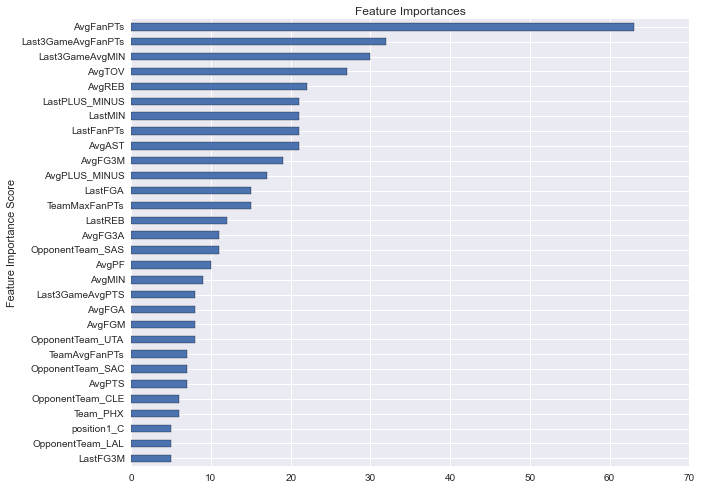

In [350]:
plot_importance(model1)

In [137]:
from ggplot import *
def plot_predictions(xgbmodel,predictors,pred_label,data,data_label): 
    data[pred_label] = xgbmodel.predict(data[predictors])
    data['NewGameFanPTs'] = data_label
    plot_obj = ggplot(aes(x='NewGameFanPTs', y=pred_label, colour='Rank_dup'), data=data)+geom_point()+\
    ggtitle(pred_label+" Prediction Performance")+ geom_abline(intercept = 0, slope = 1)
    return(plot_obj)

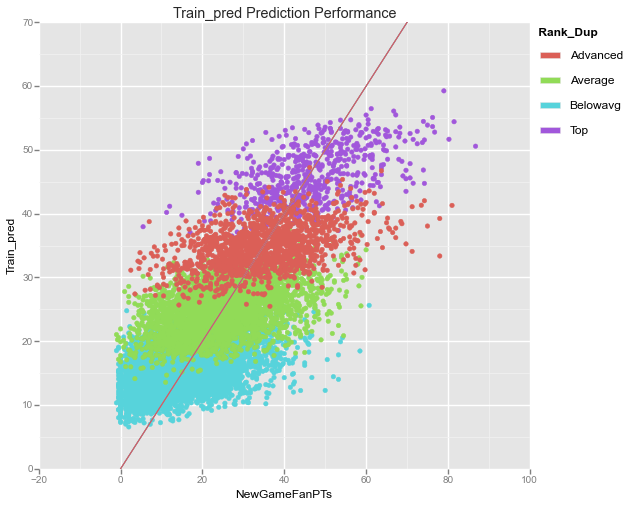

<ggplot: (285747925)>

In [138]:
plot_predictions(model1,predictors,'Train_pred',train_df,y_train)

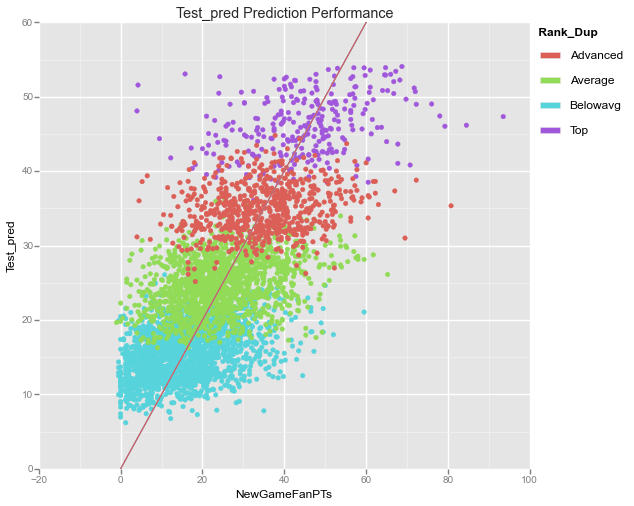

<ggplot: (279054765)>

In [139]:
plot_predictions(model1,predictors,'Test_pred',valid_df,y_valid)

#Testing

In [160]:
test_df = pd.read_csv('Data/experiment_test_df_0313.csv')

In [162]:
test_predictions = model1.predict(test_df[predictors])

In [164]:
test_df.columns

Index([u'fullName', u'Player_ID', u'LastFanPTs', u'AvgFanPTs', u'AvgPTS',
       u'LastPT', u'AvgMIN', u'LastMIN', u'AvgFGM', u'LastFGM', 
       ...
       u'OpponentTeam_CHI', u'OpponentTeam_SAS', u'OpponentTeam_MEM',
       u'OpponentTeam_WAS', u'OpponentTeam_DAL', u'GameMonth_1',
       u'GameMonth_2', u'GameMonth_11', u'GameMonth_12', u'GameMonth_10'],
      dtype='object', length=110)

In [165]:
test_result_df = pd.DataFrame({'fullName':test_df['fullName'],'Player_ID':test_df['Player_ID'],\
                           'prediction':test_predictions})

In [176]:
test_result_df.head()

Player_ID             fullName  prediction
0     203521  Matthew Dellavedova   16.859592
1     202389       Timofey Mozgov   12.560592
2     201168       Tiago Splitter   12.859308
3       2747           J.R. Smith   21.988348
4     203471      Dennis Schroder   16.945889

###We need to combine our predictions with salary costs as inputs for our second stage optimizer problem.

In [242]:
with open('Data/SalaryHistory031316/2016-03-13.csv','rb') as data_file:
    playcost_0313 = pd.read_csv(data_file,sep=";")

In [243]:
playcost_0313.shape

(146, 14)

In [244]:
playcost_0313['DK Salary'] = playcost_0313['DK Salary'].astype(str).map(
    lambda ele: ele if ele == 'nan' else int(ele.replace('$', '').replace(',', '')))

In [245]:
playcost_0313['fullName'] = playcost_0313['Name'].astype(str).map(lambda nn: nn.split(', ')[1]+' '\
                                                      + nn.split(', ')[0])

In [256]:
test_result_df.fullName = test_result_df.fullName.map(lambda x: x.replace('.',''))

In [258]:
playcost_0313.fullName = playcost_0313.fullName.map(lambda x: x.replace('.',''))

In [264]:
names_tofix = {'Louis Williams':'Lou Williams','Larry Nance':'Larry Nance Jr'}

In [272]:
playcost_0313.fullName = playcost_0313.fullName.map(lambda x: names_tofix[x] if x in names_tofix.keys() else x) 

In [273]:
set(playcost_0313.fullName) - set(test_result_df.fullName)

{'Anthony Brown',
 'Branden Dawson',
 'CJ Wilcox',
 'Caron Butler',
 'Chris Johnson',
 'Chris McCullough',
 'Cleanthony Early',
 'Damien Inglis',
 'Dante Exum',
 'Duje Dukan',
 'Eric Moreland',
 'Glenn Robinson III',
 'James Anderson',
 'James Jones',
 'Joe Ingles',
 "Johnny O'Bryant",
 'Jordan McRae',
 'Joseph Young',
 'Kevin Seraphin',
 'Kirk Hinrich',
 'Lamar Patterson',
 'Louis Amundson',
 'Luc Mbah a Moute',
 'Markel Brown',
 'Maurice Williams',
 'Mike Muscala',
 'Pablo Prigioni',
 'Rakeem Christmas',
 'Rashad Vaughn',
 'Robert Sacre',
 'Sasha Kaun',
 'Sasha Vujacic',
 'Sean Kilpatrick',
 'Sergey Karasev',
 'Seth Curry',
 'Shayne Whittington',
 'Solomon Hill',
 'Steve Novak',
 'Tarik Black',
 'Tibor Pleiss',
 'Tim Hardaway Jr',
 'Tyler Ennis',
 'Walter Tavares'}

In [294]:
ntest_result_df = pd.merge(test_result_df,playcost_0313[['fullName','DK Salary','Pos','Team']],on='fullName')

In [251]:
playcost_0313[['fullName','DK Salary','Pos']].shape

(146, 3)

In [295]:
ntest_result_df.shape

(104, 6)

In [296]:
ntest_result_df.head()

Player_ID             fullName  prediction  DK Salary Pos Team
0     203521  Matthew Dellavedova   16.859592       3300  PG  cle
1     202389       Timofey Mozgov   12.560592       3200   C  cle
2     201168       Tiago Splitter   12.859308       3000   C  atl
3       2747             JR Smith   21.988348       4800  SG  cle
4     203471      Dennis Schroder   16.945889       4200  PG  atl

In [278]:
test_result_df[~test_result_df.fullName.isin(ntest_result_df.fullName)]

Player_ID          fullName  prediction
10       2590       Mo Williams   11.922332
19       2746        Josh Smith   13.326095
28     202362  Lance Stephenson   21.427237
38     200745   Andrea Bargnani   11.052099
39       2207       Joe Johnson   29.154091
82     201978    Chase Budinger   12.222034

Although we can't match all the malary cost, actually, there are players not playing today. So we finish the step of combining our predictions with salary costs as inputs for our second stage optimizer problem

In [297]:
ntest_result_df.head() 

Player_ID             fullName  prediction  DK Salary Pos Team
0     203521  Matthew Dellavedova   16.859592       3300  PG  cle
1     202389       Timofey Mozgov   12.560592       3200   C  cle
2     201168       Tiago Splitter   12.859308       3000   C  atl
3       2747             JR Smith   21.988348       4800  SG  cle
4     203471      Dennis Schroder   16.945889       4200  PG  atl

##Run our optimizer

In [300]:
ntest_result_df.rename(columns={'fullName':'Name','prediction':'DK Pts'},inplace=True)

In [343]:
ntest_result_df.drop_duplicates('Player_ID',inplace=True)

In [301]:
import pulp

In [302]:
def LineUpOptimizer(specificDate):
    # initialize variables
    playerPositions = specificDate['Pos'].tolist()
    teams = specificDate['Team'].tolist()
    playerNames = specificDate['Name'].tolist()
    #playerTeams = tuple(specificDate['Team'].unique())
    playerCosts = tuple(specificDate['DK Salary'])
    playerPoints = tuple(specificDate['DK Pts'])
    salaryCap = 50000
    numOfPlayers = range(len(playerCosts))
    
    # formulate linear programming problem
    problem = pulp.LpProblem("Optimal Lineup", pulp.LpMaximize)
    # create variable to represent each player
    playerInLineup = pulp.LpVariable.dicts("Players", [i for i in numOfPlayers], 0, 1, cat="Binary")
    # create objective: maximize sum of player points
    problem += pulp.lpSum(playerInLineup[i] * playerPoints[i] for i in numOfPlayers)
    
    # constraint: each player can only be chosen at most once
    for i in numOfPlayers:
        problem += pulp.lpSum(playerInLineup[i]) <= 1
    # constraints: sum of player costs must be less than or equal to the salary cap
    problem += sum(playerInLineup[i] * playerCosts[i] for i in numOfPlayers) <= salaryCap
    # constraint: teams must have 8 players
    problem += pulp.lpSum(problem.variables()) == 8
    # positions
    # constraint: 1 <= number of PG <= Max 3
    pointguards = tuple(specificDate['Pos'] == 'PG')
    problem += pulp.lpSum(playerInLineup[i] * pointguards[i] for i in numOfPlayers) >= 1
    problem += pulp.lpSum(playerInLineup[i] * pointguards[i] for i in numOfPlayers) <= 3

    # constraint: 1 <= number of SG <= Max 3
    shootguards = tuple(specificDate['Pos'] == 'SG')
    problem += pulp.lpSum(playerInLineup[i] * shootguards[i] for i in numOfPlayers) >= 1
    problem += pulp.lpSum(playerInLineup[i] * shootguards[i] for i in numOfPlayers) <= 3

    # constraint: 1 <= number of SF <= Max 3
    smallforward = tuple(specificDate['Pos'] == 'SF')
    problem += pulp.lpSum(smallforward[i] * playerInLineup[i] for i in numOfPlayers) >= 1
    problem += pulp.lpSum(smallforward[i] * playerInLineup[i] for i in numOfPlayers) <= 3

    # constraint: 1 <= number of PF <= Max 3
    powerfoward = tuple(specificDate['Pos'] == 'PF')
    problem += pulp.lpSum(powerfoward[i] * playerInLineup[i] for i in numOfPlayers) >= 1
    problem += pulp.lpSum(powerfoward[i] * playerInLineup[i] for i in numOfPlayers) <= 3

    # constraint: 1 <= number of C <= Max 2
    centers = tuple(specificDate['Pos'] == 'C')
    problem += pulp.lpSum(playerInLineup[i] * centers[i] for i in numOfPlayers) <= 2
    problem += pulp.lpSum(playerInLineup[i] * centers[i] for i in numOfPlayers) >= 1
    
    # output the calculated predicted lineup
    cost = 0
    points = 0

    predicted = set()
    if problem.solve() == 1:
        for pos in range(len(numOfPlayers)):
            if playerInLineup[pos].value() == 1:
                name = playerNames[pos]
                predicted.add(name)
                cost += playerCosts[pos]
                points += playerPoints[pos]
                print '%25s, Position = %2s, Price = %5.f, Points = %3.2f, Team = %3s' \
                      % (playerNames[pos], playerPositions[pos], playerCosts[pos],
                         playerPoints[pos], teams[pos])
        print '\nTotal Team Cost: %5d\nTotal Team Points: %5.2f' % (cost, points)
    else:
        print 'Error finding solution'
        
    return(predicted,cost, points)

In [344]:
PredictedLineUp, cost, points = LineUpOptimizer(ntest_result_df)

          Thabo Sefolosha, Position = SF, Price =  3200, Points = 18.48, Team = atl
            Blake Griffin, Position = PF, Price =  8200, Points = 44.02, Team = lac
              Paul George, Position = SF, Price =  8100, Points = 44.53, Team = ind
           DeAndre Jordan, Position =  C, Price =  7700, Points = 41.31, Team = lac
              Rajon Rondo, Position = PG, Price =  7800, Points = 44.64, Team = sac
           Jerryd Bayless, Position = PG, Price =  4700, Points = 25.11, Team = mil
  Michael Carter-Williams, Position = PG, Price =  5300, Points = 28.39, Team = mil
              Kobe Bryant, Position = SG, Price =  5000, Points = 27.24, Team = lal

Total Team Cost: 50000
Total Team Points: 273.72


In [304]:
with open('Data/allplayerFantasyGameLogs_0314.pickle','rb') as data_file:
    result_df = pickle.load(data_file)

In [313]:
result_df = result_df.ix['2016-03-13']

In [315]:
result_df[result_df.fullName.isin(list(PredictedLineUp))][['fullName','FanPTs']]

fullName  FanPTs
GAME_DATE                          
2016-03-13   Jerryd Bayless   22.25
2016-03-13  Thabo Sefolosha   26.25
2016-03-13      Paul George   22.50
2016-03-13      Kobe Bryant   18.50
2016-03-13      Rajon Rondo   23.50
2016-03-13   DeAndre Jordan   29.25

#Why do we miss another two players?

Experiment 2

In [318]:
ntest_result_df2 = ntest_result_df[~ntest_result_df.Name.isin(["Blake Griffin","Michael Carter-Williams"])]

In [319]:
PredictedLineUp2, cost2, points2 = LineUpOptimizer(ntest_result_df2)

          Thabo Sefolosha, Position = SF, Price =  3200, Points = 18.48, Team = atl
              Greg Monroe, Position =  C, Price =  6300, Points = 34.01, Team = mil
              Paul George, Position = SF, Price =  8100, Points = 44.53, Team = ind
              Rajon Rondo, Position = PG, Price =  7800, Points = 44.64, Team = sac
              George Hill, Position = PG, Price =  4800, Points = 25.58, Team = ind
              Kobe Bryant, Position = SG, Price =  5000, Points = 27.24, Team = lal
         DeMarcus Cousins, Position = PF, Price = 10200, Points = 53.07, Team = sac
            Arron Afflalo, Position = SG, Price =  4600, Points = 24.87, Team = nyk

Total Team Cost: 50000
Total Team Points: 272.43


In [328]:
result_df[result_df.fullName.isin(list(PredictedLineUp2))][['fullName','FanPTs']]

fullName  FanPTs
GAME_DATE                           
2016-03-13     Arron Afflalo   15.25
2016-03-13       Greg Monroe   24.25
2016-03-13       George Hill   14.50
2016-03-13   Thabo Sefolosha   26.25
2016-03-13  DeMarcus Cousins   61.50
2016-03-13       Paul George   22.50
2016-03-13       Kobe Bryant   18.50
2016-03-13       Rajon Rondo   23.50

In [329]:
sum(result_df[result_df.fullName.isin(list(PredictedLineUp2))][['fullName','FanPTs']].FanPTs)

206.25

In [345]:
best0313_fromPred = ntest_result_df[ntest_result_df.Name.isin(['Giannis Antetokounmpo','Shelvin Mack','Khris Middleton',\
                                      'Thabo Sefolosha','Derrick Favors','Robin Lopez','Jerryd Bayless',\
                                      'Carmelo Anthony'])][['Name','DK Salary','DK Pts']]

In [346]:
best0313_fromPred

Name  DK Salary     DK Pts
12        Thabo Sefolosha       3200  18.483992
24         Derrick Favors       7100  35.422897
31        Khris Middleton       7300  36.721508
39            Robin Lopez       5900  26.451281
47        Carmelo Anthony       8300  40.693798
57         Jerryd Bayless       4700  25.110645
85  Giannis Antetokounmpo       8700  36.089252
89           Shelvin Mack       4600  22.466486

In [348]:
best0313_fromPred['DK Pts'].sum()

241.43987

#Conclusion

Clearly, our system is not good enough. Due to the most uncertain and challenging task in predicting player's daily value, our Lineup may not be really optimal in real-life experiments. 

However, the good news is that we had successfully implemented our algorithm from end to end and figure out ways to test our algorithm. 

There are two approaches we think can help improve our algorithm for final prediction.
- use the idea of "bagging" to improve our prediction model or the final lineup results.
- incorporate more information about risk and uncertainty into our optimizer